In [2]:
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# Reduce logging output.
tf.get_logger().setLevel('ERROR')
logging.set_verbosity(logging.ERROR)

# Getting started

## Data
We will try to solve the [Large Movie Review Dataset v1.0](http://ai.stanford.edu/~amaas/data/sentiment/) task [(Mass et al., 2011)](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf). The dataset consists of IMDB movie reviews labeled by positivity from 1 to 10. The task is to label the reviews as **negative** or **positive**.

In [12]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

train_df, test_df = download_and_load_datasets()
print(f'len train_df:{len(train_df)}')
train_df.head()

len train_df:25000


,sentence,sentiment,polarity
0,After a promising first 25 minutes that makes ...,4,0
1,Imagine being so hampered by a bureaucracy tha...,8,1
2,Why oh why can't anyone make a decent film out...,3,0
3,I was rooting for this film as it's a remake o...,1,0
4,This was one of the funniest and greatest sitc...,10,1


## Model
### Tensor Data

In order to use Tensorflow 2.1.0 we need to use td.data.Dateset. This objects are data containers useful to apply tensorflow pipelines.

In [18]:
validation_qty = int(len(train_df)*0.1)
train_ds = tf.data.Dataset.from_tensor_slices((list(train_df['sentence'].values)[validation_qty:], 
                                              list(train_df['polarity'].values)[validation_qty:])
                                            )

validate_ds = tf.data.Dataset.from_tensor_slices((list(train_df['sentence'].values)[:validation_qty], 
                                              list(train_df['polarity'].values)[:validation_qty])
                                            )


test_ds = tf.data.Dataset.from_tensor_slices((list(test_df['sentence'].values), 
                                              list(test_df['polarity'].values))
                                            )
train_examples_batch, train_labels_batch = next(iter(dataset.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"Saw this film in August at the 27th Annual National Association of Black Journalists Convention in Milwaukee, WI, it's first public screening. THE FILM IS GREAT!!! Derek Luke is wonderful as Antwone Fisher. This young actor has a very bright future. The real Antwone Fisher did a great job writing the film and Denzel's direction is right on the money. See it opening weekend. You won't be disappointed.",
       b'I remember this show from Swedish television. I was only 7 years of age and it scared me beyond belief.<br /><br />I would love to revisit this series and see if it was just as excellent as remember though i suspect my taste and demands have changed.<br /><br />Although this was released before alien and a plethora of other space-thrillers i suspect that it has its root in scary movies from the 50:s and the political climate of the 70:s. When i think of it, this was a real sci-fi, a movie trying to discuss scientific and pol

### Feature columns

TF-Hub provides a [feature column](https://www.tensorflow.org/hub/api_docs/python/hub/text_embedding_column.md) that applies a module on the given text feature and passes further the outputs of the module. In this tutorial we will be using the [nnlm-en-dim128 module](https://tfhub.dev/google/nnlm-en-dim128/1). For the purpose of this tutorial, the most important facts are:

* The module takes **a batch of sentences in a 1-D tensor of strings** as input.
* The module is responsible for **preprocessing of sentences** (e.g. removal of punctuation and splitting on spaces).
* The module works with any input (e.g. **nnlm-en-dim128** hashes words not present in vocabulary into ~20.000 buckets).

In [118]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:1])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 4.56216812e-01,  1.10036425e-01,  2.18274016e-02,
         1.39539480e-01,  1.47129353e-02, -4.39994484e-02,
         1.95757061e-01, -1.23551428e-01,  1.14617862e-01,
        -8.50839838e-02, -2.83196848e-02, -3.67758244e-01,
        -2.06497207e-01, -2.00883418e-01, -1.47509530e-01,
         3.15800756e-02, -7.28541240e-02,  9.20439735e-02,
        -1.22595333e-01,  5.98617792e-01, -3.39370314e-03,
         9.89742130e-02,  2.07929201e-02,  1.63649559e-01,
         9.55127478e-02, -5.61356777e-03, -1.08779103e-01,
        -1.06894337e-01, -1.67396963e-01,  7.32648373e-02,
         6.24098517e-02,  5.88044815e-04,  2.29244400e-02,
        -3.40163447e-02,  2.05800220e-01, -1.32402882e-01,
        -9.12887231e-02, -1.55842185e-01, -6.51008636e-02,
         1.12249866e-01, -3.36622745e-02, -2.26004105e-02,
        -2.67575774e-02,  1.24639824e-01,  3.84006128e-02,
         1.12821639e-01, -2.82189790e-02, -3.56720865e-01,
      

### DNN Classifier

For classification we can use a DNN Classifier.

In [119]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_21 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 124,647,361
Trainable params: 124,647,361
Non-trainable params: 0
_________________________________________________________________


In [120]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training

Train the estimator for a reasonable amount of steps.

# Prediction

Run predictions for both training and test set.

In [121]:
history = model.fit(train_ds.shuffle(10000).batch(512),
                    epochs=5,
                    validation_data=validate_ds.batch(512),
                    verbose=1)

Train for 44 steps, validate for 5 steps
Epoch 1/5
44/44 [==============================] - 60s 1s/step - loss: 0.6911 - accuracy: 0.5374 - val_loss: 0.6492 - val_accuracy: 0.7044
Epoch 2/5
44/44 [==============================] - 58s 1s/step - loss: 0.6049 - accuracy: 0.8113 - val_loss: 0.5795 - val_accuracy: 0.8348
Epoch 3/5
44/44 [==============================] - 60s 1s/step - loss: 0.5548 - accuracy: 0.9049 - val_loss: 0.5665 - val_accuracy: 0.8692
Epoch 4/5
44/44 [==============================] - 61s 1s/step - loss: 0.5347 - accuracy: 0.9436 - val_loss: 0.5614 - val_accuracy: 0.8716
Epoch 5/5
44/44 [==============================] - 58s 1s/step - loss: 0.5234 - accuracy: 0.9617 - val_loss: 0.5621 - val_accuracy: 0.8748


In [122]:
results = model.evaluate(test_ds.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 2s - loss: 0.5662 - accuracy: 0.8698
loss: 0.566
accuracy: 0.870


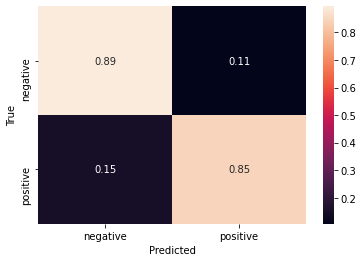

In [123]:
LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
cm = tf.math.confusion_matrix(test_df["polarity"], 
                              model.predict(test_ds.batch(512)) > 0.5)

# Normalize the confusion matrix so that each row sums to 1.
cm = tf.cast(cm, dtype=tf.float32)
cm = cm / tf.math.reduce_sum(cm, axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

In [124]:
model.predict(['It was great'])

array([[0.98417956]], dtype=float32)